Liv Jewel D. Monsalud

Heart Alvern Sumicad


The Sessa Empirical Estimator (SEE) is a data-driven method designed to estimate the duration of pharmacological prescriptions when exact data on prescription duration is missing. It is particularly useful in pharmacoepidemiologic studies where understanding treatment persistence, effectiveness, or safety is crucial​

### How the Sessa Empirical Estimator (SEE) Works  

The SEE algorithm estimates medication duration using k-means clustering on prescription refill patterns. It follows five key steps:  

1. **Compute ECDF** – Calculates temporal distances between refills, retaining the lower 80% to filter out extreme cases.  
2. **Select Random Pairs** – Randomly samples prescription pairs to avoid overrepresenting frequent refills.  
3. **Cluster Distances** – Standardizes refill intervals and groups them using k-means, selecting the optimal cluster count via Silhouette Analysis.  
4. **Estimate Duration** – Determines median prescription duration from the probability density function (PDF) within each cluster.  
5. **Calculate End of Supply** – Adds the estimated duration to the fill date to determine when the supply runs out.

We will be using the simulated dataset

https://github.com/Masswear/BeyondThresholds/

Convert R to Python

In [114]:
import numpy as np
import pandas as pd
from scipy.stats import norm, logistic
from datetime import datetime, timedelta

# Logistic function for groups 3 and 4
def logistic_function(x, L=0, S=1, D=1, h=1, B=None):
    if B is None:
        B = np.array(x) - D  # Ensure B is a NumPy array
    return [(h - (5 * L)) / (1 + np.exp(S * B_i)) + L for B_i in B]

# Function to create offset for different groups
def offset(group, n):
    if group == 1:  # High adherence
        L, U, m, s = -0.1, 0.2, 0.05, 0.1
    elif group == 2:  # Erratic adherence
        L, U, m, s = -0.2, 1.2, 0, 1
    elif group == 3:  # Gradual decline
        L, U, m, s = 0.5, 1.5, 1, 1
    elif group == 4:  # Intermittent adherence
        L, U, m, s = 0.8, 1.2, 1, 0.1
    elif group == 5:  # Partial drop-off
        L, U, m, s = 0.5, 1.5, 1, 1
    elif group == 6:  # Non-persistence
        n = np.random.choice([2, 3])
        L, U, m, s = -0.2, 0.8, 0.3, 1
    else:
        return []

    pL, pU = norm.cdf(L, loc=m, scale=s), norm.cdf(U, loc=m, scale=s)
    offsets = norm.ppf(np.random.uniform(pL, pU, n), loc=m, scale=s)

    if group == 3:
        t = np.linspace(0, 2, n)
        offsets *= t
    elif group == 4:
        offsets *= logistic_function(range(1, n + 1), L=0.05, S=10, D=n, B=np.sin(2 * np.array(range(1, n + 1)) - n))
    elif group == 5:
        offsets *= logistic_function(range(1, n + 1), L=0.05, S=-15, D=n // 3)

    return offsets

# Function to create refill pattern for patients
def refills(patient_id, group, start_date="01.01.2022", disp_durations=[30, 60, 90], dist_durations=[0.3, 0.5, 0.2]):
    n = 10  # Adjust as needed
    offsets = offset(group, n)

    # Debug: Check if offsets are empty
    if len(offsets) < 2:
        print(f"⚠️ Patient {patient_id}, Group {group}: Not enough offsets ({len(offsets)})!")
        return pd.DataFrame()

    durations = np.random.choice(disp_durations, size=len(offsets)-1, p=dist_durations)
    durations = np.insert(durations, 0, 30)  # Initial fill

    # Ensure durations and offsets match
    if len(durations) != len(offsets):
        print(f"⚠️ Patient {patient_id}, Group {group}: Durations/Offsets mismatch! {len(durations)} vs {len(offsets)}")
        return pd.DataFrame()

    start_date = datetime.strptime(start_date, "%d.%m.%Y")
    refill_dates = [start_date + timedelta(days=int(sum(durations[:i + 1]) + round(offsets[i] * durations[i]))) for i in range(len(durations))]

    # Debug: Print the lengths
    #print(f"✅ Patient {patient_id}, Group {group}: Durations = {len(durations)}, Dates = {len(refill_dates)}")

    # Check lengths before returning DataFrame
    if len(refill_dates) != len(durations):
        print(f"❌ Mismatch: Dates ({len(refill_dates)}) vs Durations ({len(durations)})")
        return pd.DataFrame()

    return pd.DataFrame({"GROUP": group, "PATIENT_ID": patient_id, "DATE": refill_dates, "DURATION": durations})



# Function to generate refill history for all groups
def med_events_sample(ntot, start_date="01.01.2022", tot_duration=2 * 365, dist=[0.1, 0.2, 0.2, 0.2, 0.2, 0.1]):
    mean_duration = sum([30, 60, 90] * np.array([0.3, 0.5, 0.2]))
    n = int((tot_duration / mean_duration) * 1.5)
    samples = []

    patient_id = 1
    for group, prob in enumerate(dist, start=1):
        num_patients = int(round(prob * ntot))
        for _ in range(num_patients):
            patient_df = refills(patient_id, group, start_date)
            #print(f"Patient {patient_id}, Group {group}: Length = {len(patient_df)}")  # 🔍 Debugging line

            samples.append(patient_df)
            patient_id += 1

    # Ensure only valid DataFrames are concatenated
    valid_samples = [df for df in samples if not df.empty]

    if not valid_samples:
        print("No valid samples found!")
        return pd.DataFrame()

    return pd.concat(valid_samples, ignore_index=True)


# Dichotomize LCMA
def CMA_dichot(duration, event_interval):
    return [1] * min(duration, event_interval) + [0] * max(0, event_interval - duration)

# Example: Generate refill history for 100 patients
df = med_events_sample(100)
print(df.head())


   GROUP  PATIENT_ID       DATE  DURATION
0      1           1 2022-02-03        30
1      1           1 2022-03-31        60
2      1           1 2022-07-01        90
3      1           1 2022-09-05        60
4      1           1 2022-11-03        60


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

Step 1

In [126]:
# Compute ECDF and filter lower 80%
def compute_ecdf(df):
    df = df.sort_values(by=['PATIENT_ID', 'DATE'])  # Ensure chronological order
    df['TEMP_DIST'] = df.groupby('PATIENT_ID')['DATE'].diff().dt.days
    df = df.dropna()
    threshold = np.percentile(df['TEMP_DIST'], 80)
    return df[df['TEMP_DIST'] > 0]  # Filter out negative values and retain valid entries


Step 2

In [127]:
# Select Random Pairs
def select_random_pairs(df, sample_size=1000):
    return df.sample(n=min(sample_size, len(df)), random_state=42)


Step 3

In [128]:

# Cluster Distances
def cluster_distances(df, max_clusters=10):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['TEMP_DIST']])

    best_k, best_score = 2, -1
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_k, best_score = k, score

    final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df['CLUSTER'] = final_kmeans.fit_predict(X)
    return df


Step 4

In [129]:

# Estimate Duration
def estimate_duration(df):
    cluster_durations = {}
    for cluster in df['CLUSTER'].unique():
        cluster_data = df[df['CLUSTER'] == cluster]['TEMP_DIST']
        kde = gaussian_kde(cluster_data)
        cluster_durations[cluster] = np.median(cluster_data)
    df['ESTIMATED_DURATION'] = df['CLUSTER'].map(cluster_durations)
    return df


Step 5

In [130]:

# Calculate End of Supply
def calculate_end_of_supply(df):
    df['END_OF_SUPPLY'] = df['DATE'] + pd.to_timedelta(df['ESTIMATED_DURATION'], unit='D')
    return df


Result

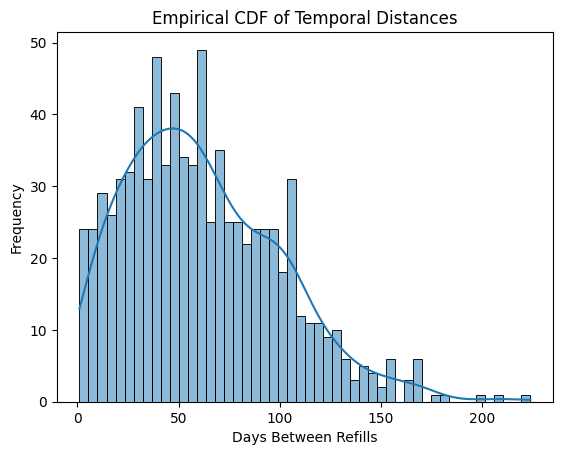

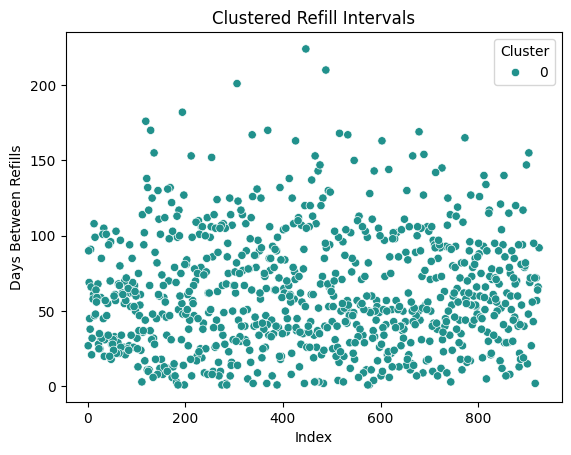

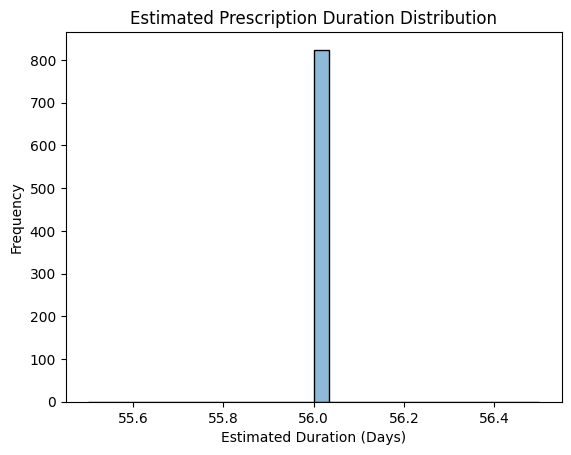

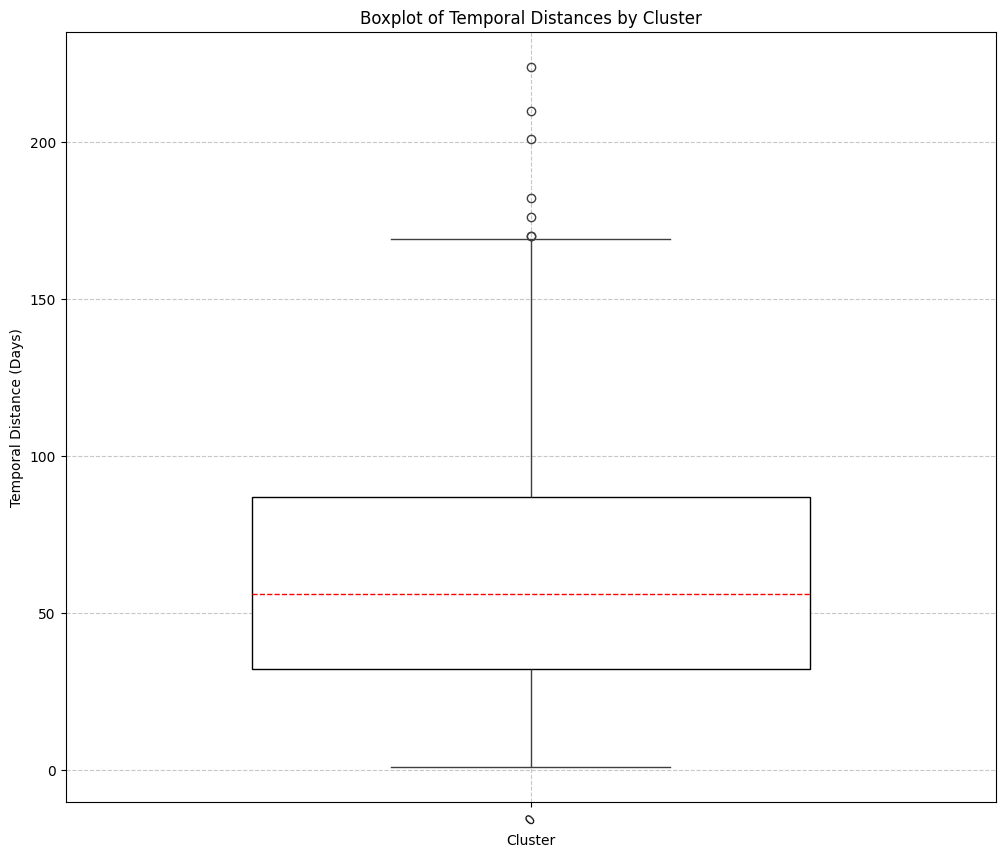

     GROUP  PATIENT_ID       DATE  DURATION  TEMP_DIST  CLUSTER  \
679      4          68 2023-12-16        90      169.0        0   
194      2          20 2023-02-08        90      182.0        0   
75       1           8 2022-10-25        60       55.0        0   
187      2          19 2023-05-06        90      117.0        0   
306      3          31 2023-07-03        90      201.0        0   

     ESTIMATED_DURATION END_OF_SUPPLY  
679                56.0    2024-02-10  
194                56.0    2023-04-05  
75                 56.0    2022-12-20  
187                56.0    2023-07-01  
306                56.0    2023-08-28  


In [157]:
# Visualization functions
def plot_ecdf(df):
    sns.histplot(df['TEMP_DIST'], bins=50, kde=True)
    plt.title("Empirical CDF of Temporal Distances")
    plt.xlabel("Days Between Refills")
    plt.ylabel("Frequency")
    plt.show()

def plot_clusters(df):
    sns.scatterplot(x=df.index, y=df['TEMP_DIST'], hue=df['CLUSTER'], palette='viridis')
    plt.title("Clustered Refill Intervals")
    plt.xlabel("Index")
    plt.ylabel("Days Between Refills")
    plt.legend(title="Cluster")
    plt.show()

def plot_supply_distribution(df):
    sns.histplot(df['ESTIMATED_DURATION'], bins=30, kde=True)
    plt.title("Estimated Prescription Duration Distribution")
    plt.xlabel("Estimated Duration (Days)")
    plt.ylabel("Frequency")
    plt.show()

def plot_boxplot(df):
    plt.figure(figsize=(12, 10))
    sns.boxplot(x='CLUSTER', y='TEMP_DIST', data=df, width=0.6, showfliers=True, boxprops=dict(facecolor='white', edgecolor='black'), medianprops=dict(color='red', linestyle='--'))
    plt.title('Boxplot of Temporal Distances by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Temporal Distance (Days)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Process Dataset
df = med_events_sample(100)
df = compute_ecdf(df)
df = select_random_pairs(df)
df = cluster_distances(df)
df = estimate_duration(df)
df = calculate_end_of_supply(df)

# Generate plots
plot_ecdf(df)
plot_clusters(df)
plot_supply_distribution(df)
plot_boxplot(df)

print(df.head())

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

Step 1

In [101]:

# Compute ECDF and filter lower 80%
def compute_ecdf(data):
    """Computes ECDF and retains the lower 80% to filter out extreme cases."""
    sorted_data = np.sort(data)
    cutoff = int(len(sorted_data) * 0.8)
    return sorted_data[:cutoff]


Step 2

In [100]:

# Select Random Pairs
def select_random_pairs(data, sample_size=1000):
    """Randomly selects pairs of prescription refill intervals."""
    np.random.seed(42)
    return np.random.choice(data, min(sample_size, len(data)), replace=False)


Step 3

In [144]:

# Determine Optimal Clusters using Silhouette Analysis
def cluster_distances(data):
    """Clusters refill intervals using DBSCAN and selects optimal clusters with Silhouette Analysis."""
    data = data.reshape(-1, 1)
    scaled_data = StandardScaler().fit_transform(data)
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(scaled_data)
    labels = dbscan.labels_

    # Handle noise points (-1)
    if len(set(labels) - {-1}) > 1:
        score = silhouette_score(scaled_data[labels != -1], labels[labels != -1])
        print(f"Silhouette Score: {score}")

    return labels, data.flatten()

Step 4

In [98]:

# Estimate Duration
def estimate_duration(cluster_labels, distances):
    """Estimates median prescription duration within each cluster."""
    durations = {}
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        if cluster != -1:
            cluster_values = distances[cluster_labels == cluster]
            durations[cluster] = np.median(cluster_values)
    return durations


Step 5

In [97]:

# Calculate End of Supply
def calculate_end_of_supply(df, cluster_labels, duration_estimates):
    """Calculates when the medication supply will run out based on clusters."""
    df['CLUSTER'] = cluster_labels
    df['ESTIMATED_DURATION'] = df['CLUSTER'].map(duration_estimates).fillna(30)
    df['END_OF_SUPPLY'] = df['DATE'] + pd.to_timedelta(df['ESTIMATED_DURATION'], unit='D')
    return df


In [96]:
# Apply SEE Algorithm
df = med_events_sample(100)
distances = (df['DATE'].diff().dt.days.dropna()).values
filtered_distances = compute_ecdf(distances)
sampled_distances = select_random_pairs(filtered_distances)
cluster_labels, distances = cluster_distances(sampled_distances)
duration_estimates = estimate_duration(cluster_labels, distances)
df = calculate_end_of_supply(df, cluster_labels, duration_estimates)

Silhouette Score: 0.922038016196598


Result

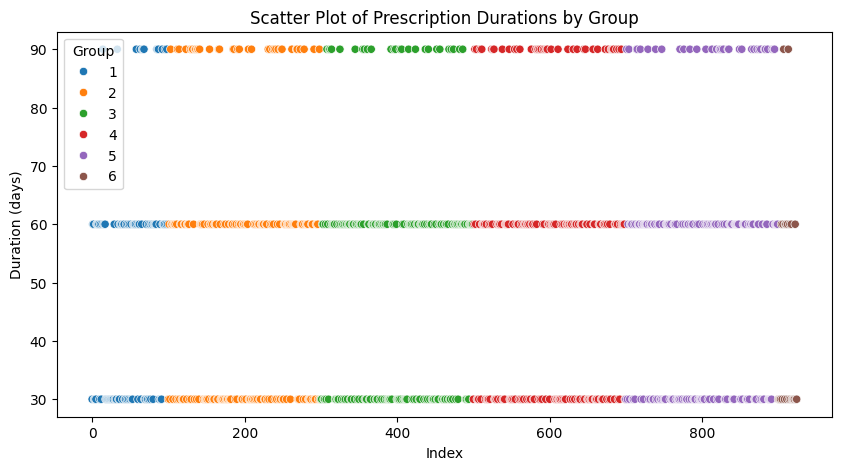

<ipython-input-106-5cf321f2d9fd>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.Series(cluster_labels, name="Number of Clusters"),


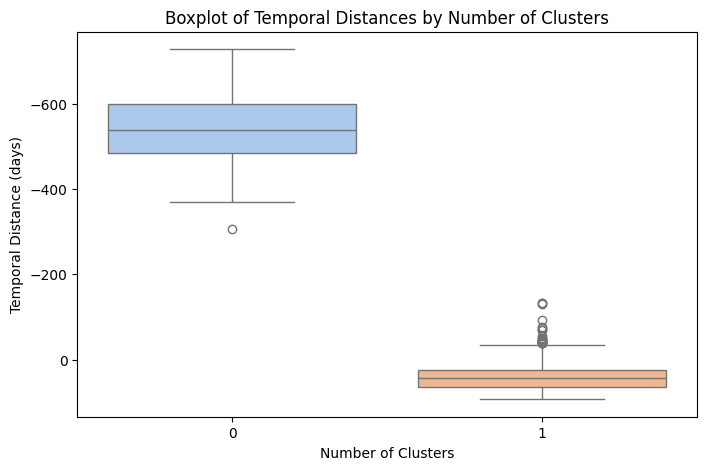

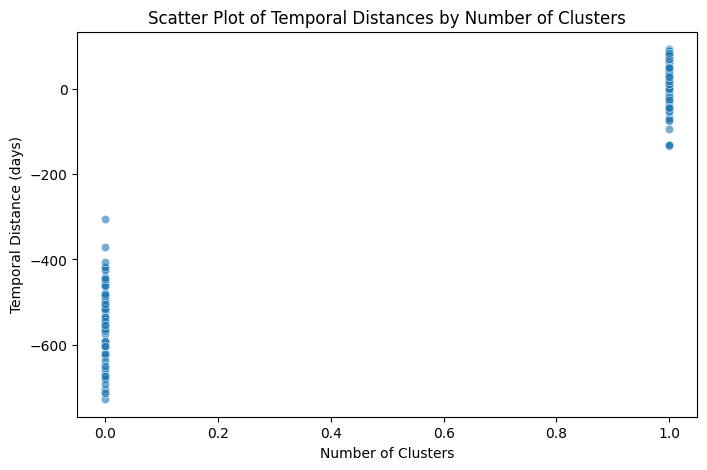

   GROUP  PATIENT_ID       DATE  DURATION END_OF_SUPPLY
0      1           1 2022-02-03        30    2022-02-04
1      1           1 2022-04-04        60    2022-04-05
2      1           1 2022-06-08        60    2022-06-09
3      1           1 2022-07-02        30    2022-07-03
4      1           1 2022-08-01        30    2022-08-02


In [106]:
# Visualizations
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df.index, y=df['DURATION'], hue=df['GROUP'], palette='tab10')
plt.title("Scatter Plot of Prescription Durations by Group")
plt.xlabel("Index")
plt.ylabel("Duration (days)")
plt.legend(title="Group")
plt.show()

# Boxplot: Temporal Distance (Days) over Number of Clusters
plt.figure(figsize=(8, 5))
sns.boxplot(x=pd.Series(cluster_labels, name="Number of Clusters"),
            y=pd.Series(sampled_distances, name="Temporal Distance (days)"),
            palette='pastel')
plt.gca().invert_yaxis()  # Correct y-axis direction
plt.title("Boxplot of Temporal Distances by Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Temporal Distance (days)")
plt.show()

# Scatter Plot: Temporal Distance vs. Cluster Labels
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pd.Series(cluster_labels, name="Number of Clusters"),
                y=pd.Series(sampled_distances, name="Temporal Distance (days)"),
                alpha=0.6)
plt.title("Scatter Plot of Temporal Distances by Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Temporal Distance (days)")
plt.show()

print(df.head())


### **Step-by-Step Comparison**
#### **1. ECDF Calculation**
   - Both methods use the same empirical cumulative distribution function (ECDF) to analyze refill gaps.
   - This step filters out extreme values (top 20% of refill intervals).

#### **2. Random Sampling of Pairs**
   - Ensures that prescription refill patterns aren't overrepresented.
   - The clustering method used in later steps does not affect this stage.

#### **3. Clustering**
   - **K-Means**: Assigns each refill interval to \( k \) predefined clusters. The number of clusters is optimized using **Silhouette Analysis**.
   - **DBSCAN**: Groups refill intervals based on density, allowing for clusters of varying shapes. It eliminates noise (outliers), which K-Means does not handle well.

#### **4. Prescription Duration Estimation**
   - **K-Means**: Uses the median refill duration of each cluster.
   - **DBSCAN**: Uses core points of dense clusters, which may exclude sparse data.

#### **5. Assigning Durations**
   - K-Means provides a structured, predetermined clustering result.
   - DBSCAN adapts to the data more flexibly but may leave some points unclassified (as noise).
